Get attention matrix from an input sequence

In [3]:
import os
import argparse
import importlib
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from dataset import PairDataset
import model
importlib.reload(model)
from modelW import TransformerClassifier
import helper


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/gladstone/engelhardt/home/hvu/anaconda3/envs/new_rna/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/gladstone/engelhardt/home/hvu/anaconda3/envs/new_rna/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/gladstone/engelhardt/home/hvu/anaconda3/envs/new_rna/lib/python3.11/site-pack

AttributeError: _ARRAY_API not found

In [4]:
negative_fold = 10
phage_embed = '/gladstone/engelhardt/lab/hvu/hackathonBio/Ecoli/phages/embed'
host_embed = '/gladstone/engelhardt/lab/hvu/hackathonBio/Ecoli/host/embed/chunk_40K'
test_prompt_fn = '/gladstone/engelhardt/lab/hvu/hackathonBio/metadata/ecoli/train_positive_pairs.txt'
save_fn = None
model_fn = '/gladstone/engelhardt/lab/hvu/hackathonBio/Ecoli/models/Transformer/chunk_40K/exp2/exp2/checkpoints/best_checkpoint.pth'
norm_constants_fn = '/gladstone/engelhardt/lab/hvu/hackathonBio/hackathon_results/tung/tung_results/ecoli/norm_constants.pth'
max_len = 200
input_dim = 4096
model_dim = 1024
num_heads = 8
num_layers = 4
dim_feedforward = 4096
dropout = 0.0
device = 'cuda'

In [5]:
pairs_df = pd.read_csv(test_prompt_fn, sep='\t')
pairs = [(row['Host_ID'], row['Phage_ID']) for _, row in pairs_df.iterrows()]
dummy_labels = [-1] * len(pairs)

test_dataset = PairDataset(
    host_root=host_embed,
    phage_root=phage_embed,
    pairs=pairs,
    labels=dummy_labels,
    max_len=max_len,
    remove_non_exist=False,
)
norm_constants = torch.load(norm_constants_fn)
test_dataset.set_norm_constants(*norm_constants)

# load model from checkpoints/best_checkpoint.pth
model = TransformerClassifier(
    input_dim=input_dim,
    model_dim=model_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    max_len=max_len,
).cuda()

checkpoint = torch.load(model_fn)

msg = model.load_state_dict(checkpoint['model_state_dict'], strict=True)
model.eval()

/gladstone/engelhardt/home/hvu/hackathonBio/Transformer/dataset.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embed_dict[embed_id] = torch.load(f'{embed_fn}').sum(dim

TransformerClassifier(
  (embedding): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (host_pos_encoder): PositionalEncoding()
  (phage_pos_encoder): PositionalEncoding()
  (transformer_encoder): ModuleList(
    (0-3): 4 x TransformerEncoderLayerWithWeights(
      (self_attn): MultiheadAttentionWithWeights(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
      )
      (linear1): Linear(in_features=1024, out_features=4096, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (linear2): Linear(in_features=4096, out_features=1024, bias=True)
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
    )
  )
  (norm): LayerNorm((1024,), eps

In [6]:


# Forward pass
with torch.no_grad():
    embeddings, label, host_lens, phage_lens = test_dataset[1000]
    print(embeddings.shape, label,  host_lens, phage_lens)
    embeddings = embeddings.unsqueeze(0).cuda()
    host_lens = torch.tensor([host_lens], dtype=torch.long).cuda()
    phage_lens = torch.tensor([phage_lens], dtype=torch.long).cuda()
    outputs = model(embeddings, host_lens, phage_lens, need_weights=True)


torch.Size([200, 4096]) tensor([-1.]) 1 1


In [39]:
def get_attention_matrix(dataset, model, idx):
    with torch.no_grad():
        embeddings, label, host_lens, phage_lens = dataset[idx]
        embeddings = embeddings.unsqueeze(0).cuda()
        host_lens = torch.tensor([host_lens], dtype=torch.long).cuda()
        phage_lens = torch.tensor([phage_lens], dtype=torch.long).cuda()
        outputs = model(embeddings, host_lens, phage_lens, need_weights=True)
    return model.attention_weights

def draw_attention_matrix(attention_matrix):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05])
    axes = []
    vmin = 0 
    vmax = 0.8
    for i in range(4):
        ax = fig.add_subplot(gs[i//2, i%2])
        im = ax.imshow(attention_matrix[i][0].cpu().numpy(), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax.set_title(f'Layer {i}')
        axes.append(ax)
    # Add colorbar to the last column
    cbar_ax = fig.add_subplot(gs[:, -1])
    fig.colorbar(im, cax=cbar_ax)
    fig.tight_layout()
    plt.show()

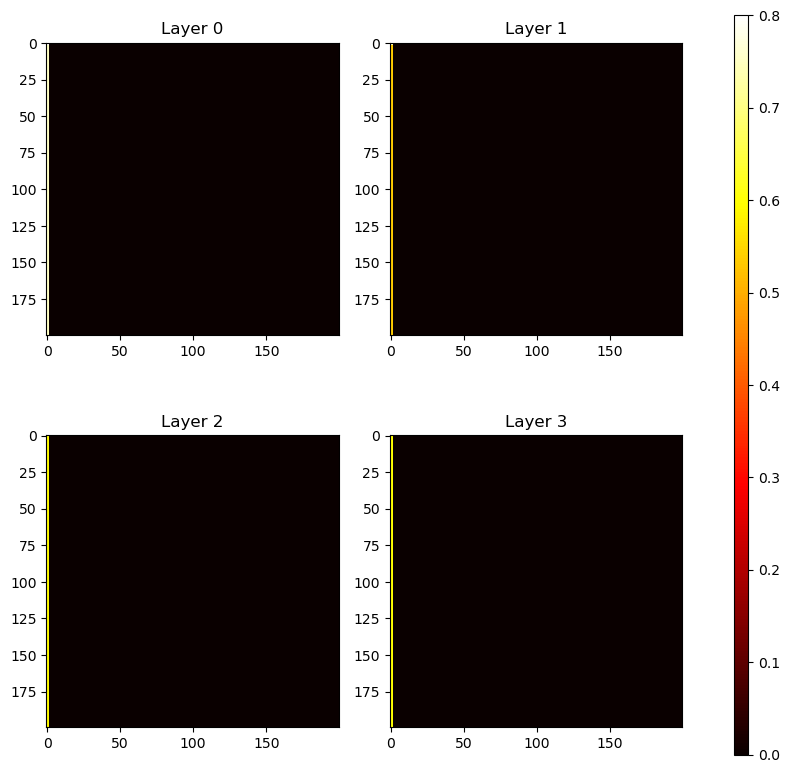

In [40]:
attn_mat = get_attention_matrix(test_dataset, model, 1000)
draw_attention_matrix(attn_mat)